In [1]:
%matplotlib inline

#System
import os
import shutil

#Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from skimage.io import imread, imshow, imsave

#Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dropout,BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger

#Preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence, to_categorical

#Models
from keras.applications.vgg16 import VGG16

#GPU
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
K.set_session(sess)

#Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

Using TensorFlow backend.
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

In [3]:
class_encoded = []
with open('static/class_encode.txt') as f:
    for line in f:
        line = line.strip()
        new_index, old_index_arr, class_name_arr = line.split(";")
        
        new_index = int(new_index)
        old_index_arr = list(map(int, old_index_arr.split("|")))
        class_name_arr = class_name_arr.split("|")
        class_encoded.append([new_index, old_index_arr, class_name_arr])

class_encoded

[[0, [0], ['-']],
 [1, [470], ['chair']],
 [2, [1734, 790, 2713], ['painting, picture', 'drawing', 'tapestry, tapis']],
 [3, [349], ['cabinet']],
 [4, [2683, 723], ['table', 'desk']],
 [5, [773], ['door']],
 [6, [1909], ['plant, flora, plant life']],
 [7, [164], ['bed']],
 [8, [1868, 688], ['pillow', 'cushion']],
 [9, [56], ['armchair']],
 [10, [1830], ['person, individual, someone, somebody, mortal, soul']],
 [11, [2472], ['sofa, couch, lounge']],
 [12, [2177], ['rug, carpet, carpeting']],
 [13, [2387], ['sink']],
 [14, [2678], ['swivel chair']],
 [15, [2585], ['stool']],
 [16, [490], ['chest of drawers, chest, bureau, dresser']],
 [17, [2597], ['stove, kitchen stove, range, kitchen range, cooking stove']],
 [18,
  [590],
  ['computer, computing machine, computing device, data processor, electronic computer, information processing system']],
 [19, [154], ['bathtub, bathing tub, bath, tub']],
 [20, [2095], ['refrigerator, icebox']],
 [21, [2984], ['wardrobe, closet, press']],
 [22, [15

In [4]:
def get_model(img_shape, num_classes):
    block0_input = Input(shape=(img_shape, img_shape, 3))

    block1_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block0_input)
    block1_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv1)
    block1_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv2)
    block1_pool1 = MaxPool2D(2)(block1_conv3)

    block2_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block1_pool1)
    block2_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv1)
    block2_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv2)
    block2_pool1 = MaxPool2D(2)(block2_conv3)

    block3_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block2_pool1)
    block3_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv1)
    block3_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv2)
    block3_pool1 = MaxPool2D(2)(block3_conv3)

    block4_conv1 = Conv2D(512, (3, 3), padding="same", activation="relu")(block3_pool1)
    block4_conv2 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv1)
    block4_conv3 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv2)
    block4_upsa1 = UpSampling2D(2, interpolation="bilinear")(block4_conv3)
    
    block5_conc1 = Concatenate()([block3_conv3, block4_upsa1])
    block5_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conc1)
    block5_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv1)
    block5_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv2)
    block5_upsa1 = UpSampling2D(2, interpolation="bilinear")(block5_conv3)

    block6_conc1 = Concatenate()([block2_conv3, block5_upsa1])
    block6_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conc1)
    block6_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv1)
    block6_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv2)
    block6_upsa1 = UpSampling2D(2, interpolation="bilinear")(block6_conv3)

    block7_conc1 = Concatenate()([block1_conv3, block6_upsa1])
    block7_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conc1)
    block7_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv1)
    block7_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv2)
    
    block8_output = Conv2D(num_classes, (1, 1), padding="same", activation="sigmoid")(block7_conv3)

    return Model(inputs=block0_input, outputs=block8_output)

In [5]:
img_shape = 256

In [6]:
model = get_model(None, 31)

In [7]:
model.load_weights("callbacks/Unet0_05.31_03-05/best_w.h5")

In [8]:
class_encoded[0][2][0]

'-'

In [9]:
import time

KeyboardInterrupt: 

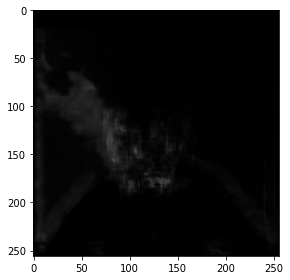

In [20]:
cap = cv2.VideoCapture(0)
try:
    
    time.sleep(5)
    while(True):
        ret, frame = cap.read()
        img = cv2.resize(frame, (img_shape, img_shape)) / 255

        pred = model.predict(np.array([img]))[0]

        i = 10
        #print(class_encoded[i][2][0])
        imshow(pred[:, :, i])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:    
    cap.release()
    cv2.destroyAllWindows()

In [16]:
cap.release()
cv2.destroyAllWindows()

In [20]:
cap = cv2.VideoCapture(0)

In [21]:
ret, frame = cap.read()

In [12]:
def pred_img(path):
    img = imread(path)
    img = cv2.resize(img, (img_shape, img_shape)) / 255

    pred = model.predict(np.array([img]))[0]
    
    for i in range(31):
        mask = pred[:, :, i]
        print(np.sum(mask) / img_shape /img_shape)
        
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        
        plt.imshow(img)
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray", norm=None)
        
        plt.title(class_encoded[i][2])
        plt.show()
    return pred

In [25]:
pred[:, :, 1].sum()

25888.375

0.7728080749511719


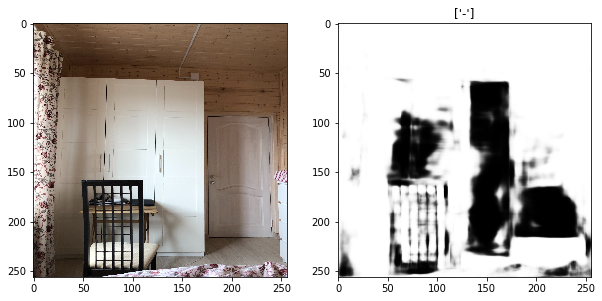

0.00977159384638071


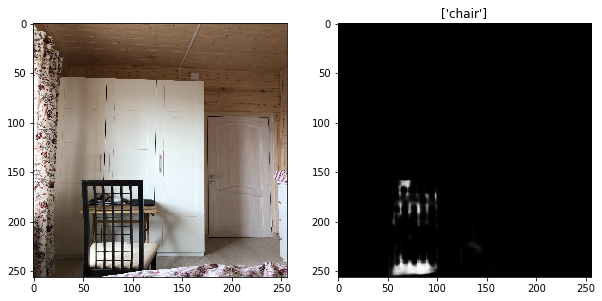

1.4247868421080057e-05


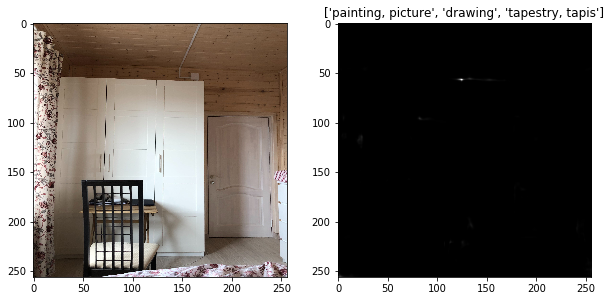

0.0464748851954937


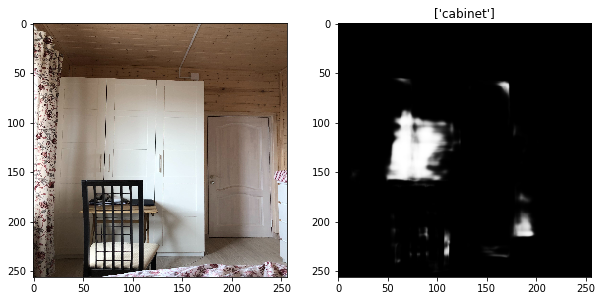

0.0037272756453603506


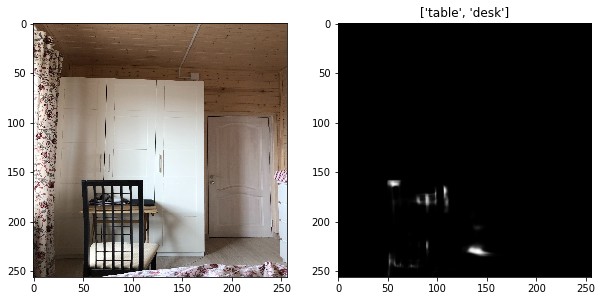

0.06679709255695343


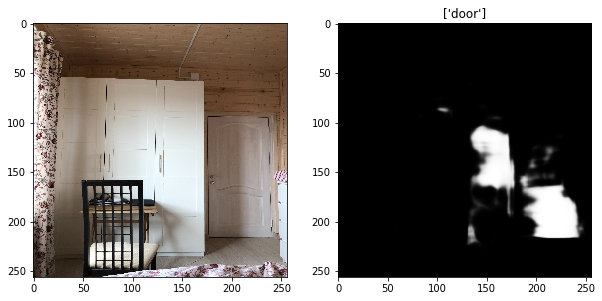

0.005888486281037331


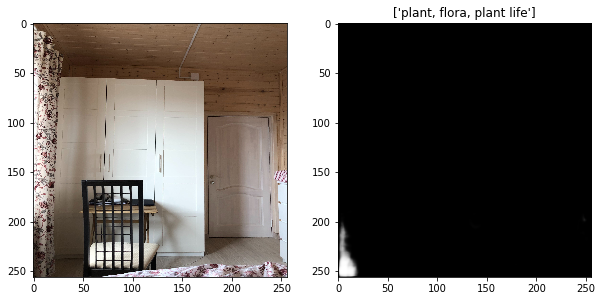

0.0017022471874952316


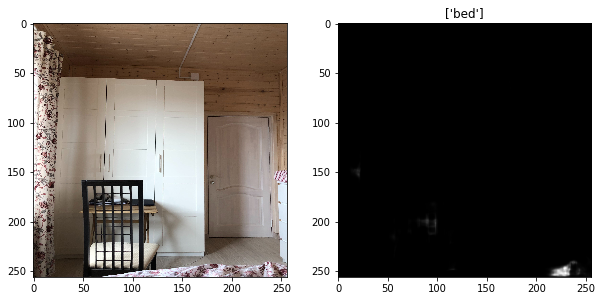

5.2523471822496504e-05


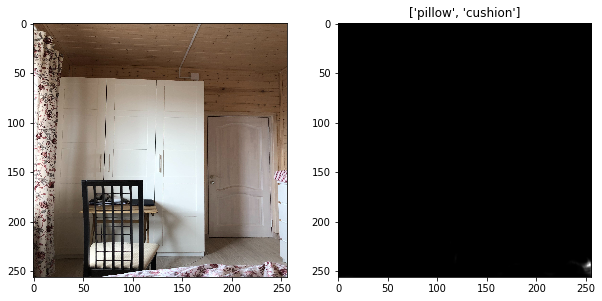

7.329163781832904e-05


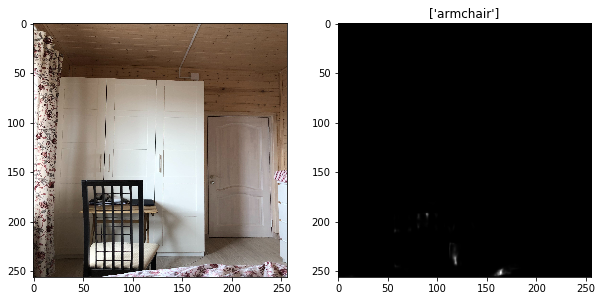

0.0020034401677548885


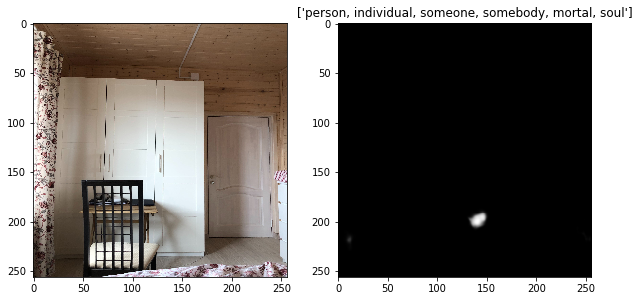

5.599173891823739e-05


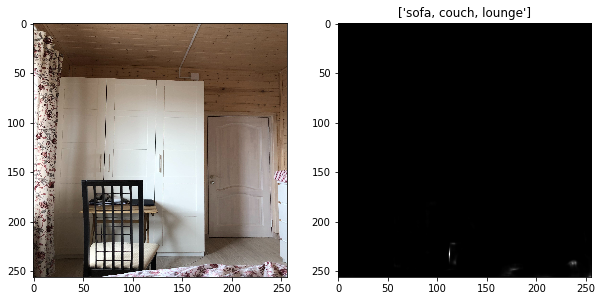

0.0005861958488821983


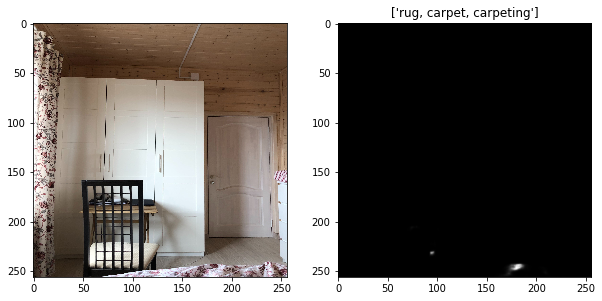

1.373135091853328e-05


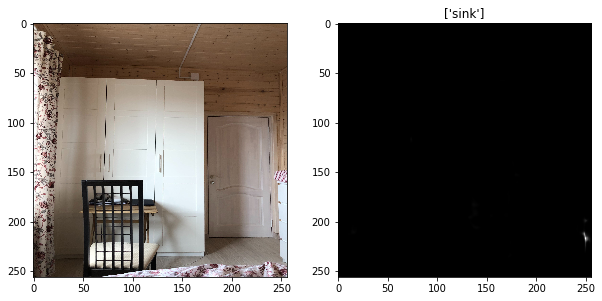

3.4732975109363906e-06


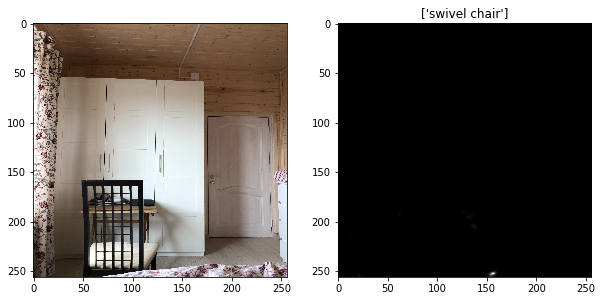

0.000532913429196924


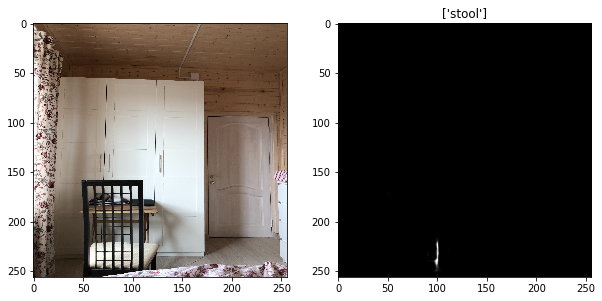

9.586257874616422e-06


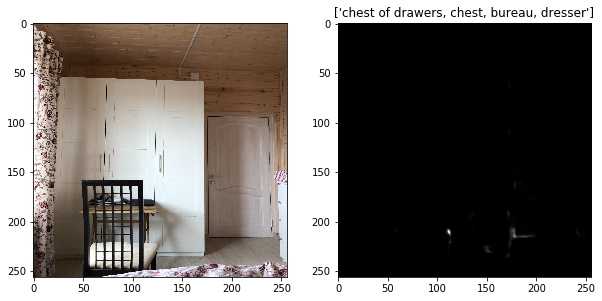

2.446287362545263e-05


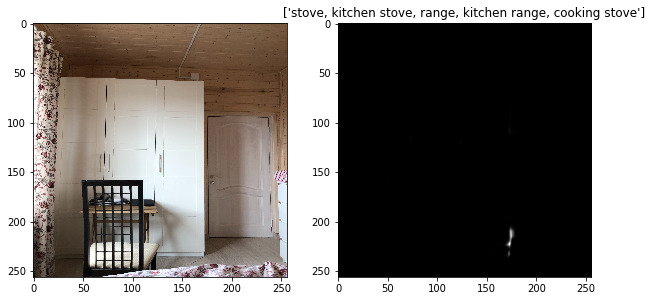

1.0998346624546684e-05


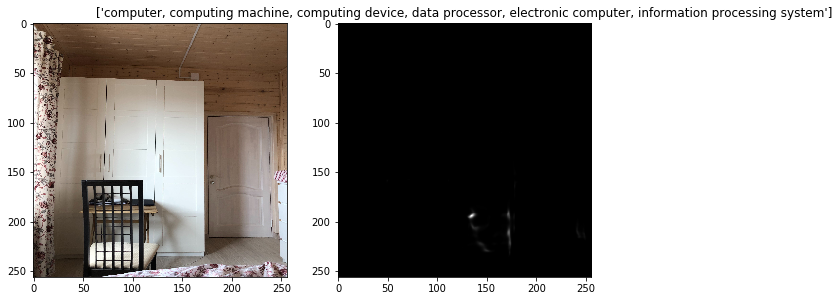

1.8281707525602542e-05


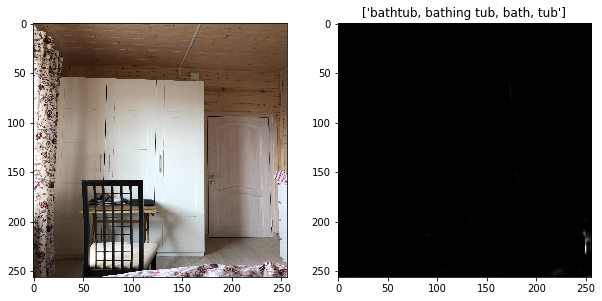

0.019222702831029892


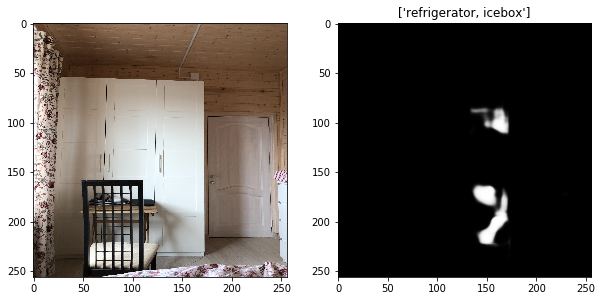

0.01707206852734089


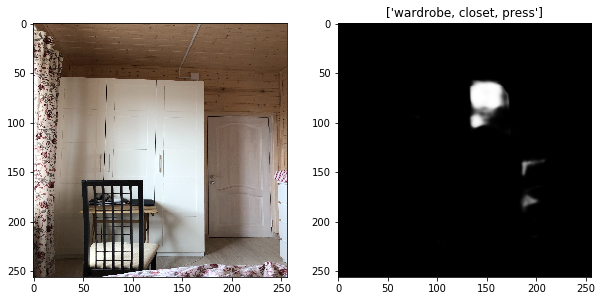

9.9716044132947e-07


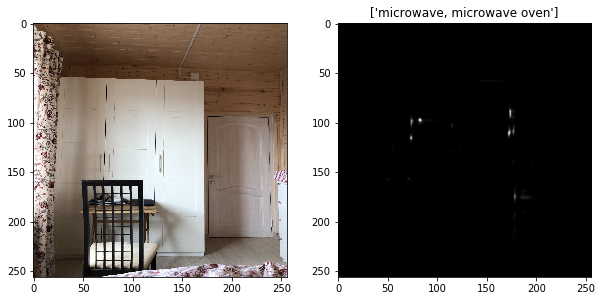

6.93162519382895e-06


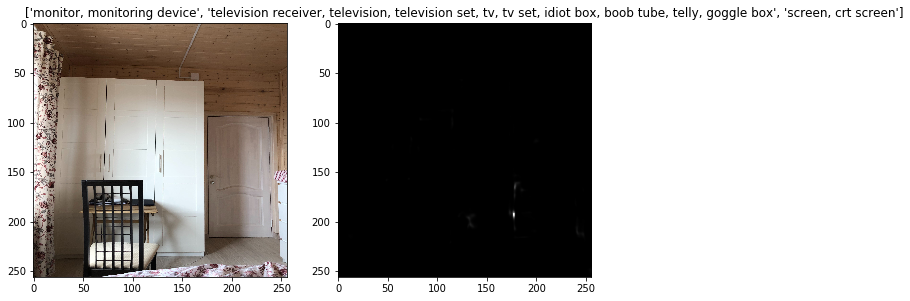

7.856875527068041e-06


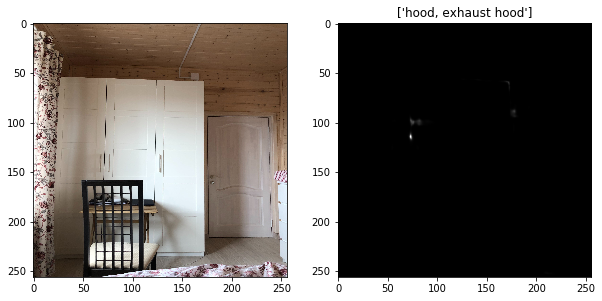

2.038615548372036e-06


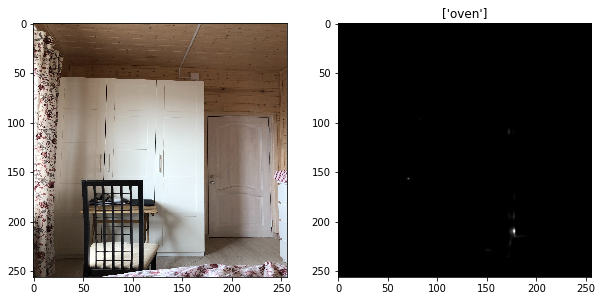

7.665971679671202e-07


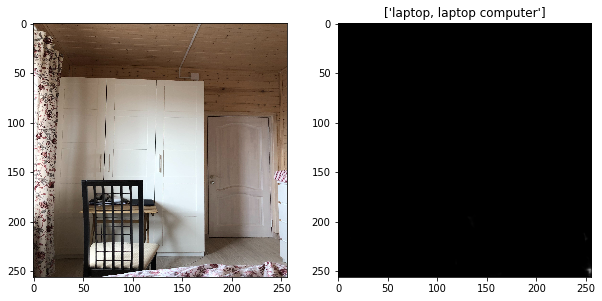

2.2248836103244685e-05


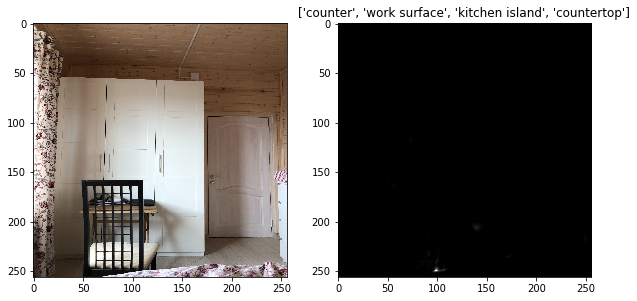

9.334294190921355e-06


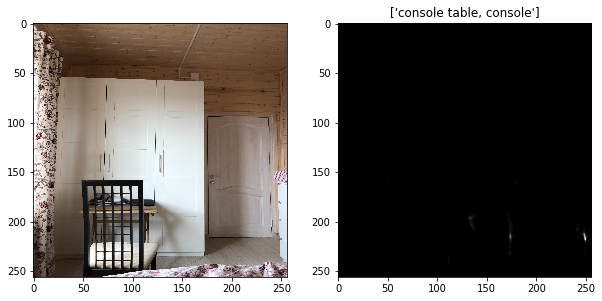

3.2052776077762246e-07


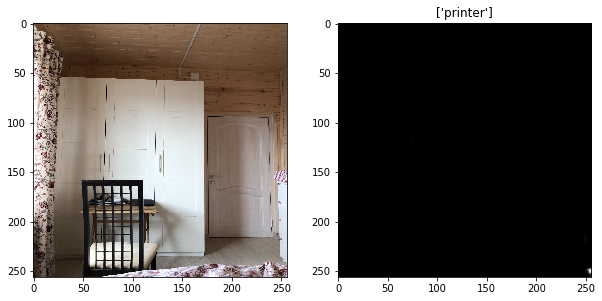

4.441076271177735e-07


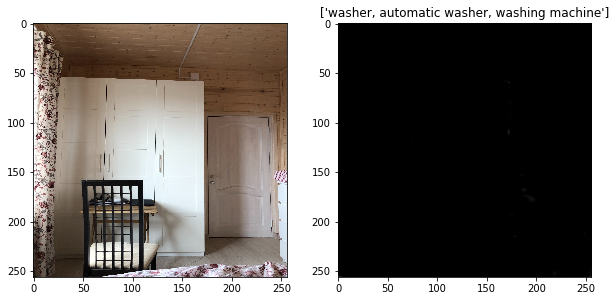

In [16]:
pred = pred_img('/home/rv/Downloads/Image from iOS.jpg')